# Objective

This code executes **segmentwise comparative shape analysis** on the point clouds for amphoras PB_L0082 and PB_2001-5-3 from the Pabuc Burnu site. This analysis includes the following:

- Outlier detection for each graduated segment of the amphoras:
     - detects and screens for outliers
     - optionally outputs a .csv file containing coordinates with all non-outliers only, in order to avoid repeating this computation


- Cloud-to-cloud distance comparison over all graduated segments of the amphoras:
    - visualization of the change in average point-to-point distance between the two segment point clouds across all graduated segments of the amphoras
        - optionally scale the average point-to-point distance for each segment by the max diameter of that segment

# I/O
**Inputs:**
 - a point/mesh cloud (.obj format) from each of two amphoras for each graduated segment

**Outputs:**
 - each input segment with outliers removed
 - the average mesh-to-mesh distance between the amphoras at each graduated segment
 - a visualization of the distribution of these average distances
 
# Description
This notebook is the user interface for the analysis. Before running the notebook, the user assigns values to the variables in the cell (i.e. block of code) under the heading "User Inputs;" this is the only cell that the user should ever edit. The subsequent cells perform the cleaning and analysis of the point clouds.

Most of the code and computational logic have been abstracted away from this notebook and consolidated in a separate utility file in order to leave this notebook user interface clean and uncluttered. I.e. the utility file is where I wrote the code which actually does the heavy lifting; this notebook uses that toolkit.

In [1]:
import sys
sys.path.insert(0,'../../')
import util, os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from skimage.io import imread
%matplotlib inline

## User Inputs
Define some information that the code needs to know. This cell is the only cell that the user should edit.

In [2]:
segments = ['rim', 'neck', 'body', 'toe']
ref = 'L0082'
comp = '2001-5-3'
save_nonoutliers = True    # whether or not to save csv files of point cloud coordinates with all outliers excluded.
                           # set True if these files do not yet exist, else False.
save_distances = True      # whether or not to save csv files of nearest-neighbor distances between objects.
                           # set True if these files do not yet exist, else False.
# plotting parameters
fontsize_xlabel = 12
fontsize_ylabel = 12
fontsize_title = 14
dpi = 300

## Outlier Removal
Outlier points are identified as points which are not close enough to other points.
Closeness threshold is the Otsu threshold as computed on the bimodal point-to-point distance distribution.

#### Read in object, convert to numpy array.
Read in a point cloud file and store as a matrix.

#### Remove outlier points. 
Remove outlier points and optionally output a .csv file containing coordinates with all non-outliers only, in order to avoid repeating this computation. If this computation has already been run for these .obj files, set **save_nonoutliers** in the above cell (i.e. block of code) to True. Otherwise, set **save_nonoutliers** to False to avoid recreating the .csv files. (See comments for "save_nonoutliers" above.)

In [3]:
for segment in segments:
    
    print (segment) # Allows the user to see which segment the code is working on
    
    if not os.path.exists('../../mapped_to_%s_cleaned/PB_%s_%s_obj' % (ref, ref, comp)):
        os.mkdir('../../mapped_to_%s_cleaned/PB_%s_%s_obj' % (ref, ref, comp))
        
    # Read ref
    obj0_filepath = '../../mapped_to_%s/PB_%s/PB_%s_%s_obj.obj' % (ref, comp, ref, segment)
    obj0_coords = util.obj_to_np(obj0_filepath)
    
    # Remove ref outlier points
    obj0_csv_path = '../../mapped_to_%s_cleaned/PB_%s_%s_obj/PB_%s_%s_obj.csv' % (ref, ref, comp, ref, segment)
    obj0_coords = util.get_nonoutliers(obj0_coords, save_nonoutliers, obj0_csv_path)

    # Read comp
    obj1_filepath = '../../mapped_to_%s/PB_%s/PB_%s_%s_obj.obj' % (ref, comp, comp, segment)
    obj1_coords = util.obj_to_np(obj1_filepath)
    
    # Remove comp outlier points
    obj1_csv_path = '../../mapped_to_%s_cleaned/PB_%s_%s_obj/PB_%s_%s_obj.csv' % (ref, ref, comp, comp, segment)
    obj1_coords = util.get_nonoutliers(obj1_coords, save_nonoutliers, obj1_csv_path)

rim
neck
body
toe


^ Each of these are status messages, which print as the corresponding segment is being processed.

## Cloud-to-Cloud Distance Comparison
For each segment, calculate the mean distance from each point in Object 1 to the nearest neighbor in Object 2.

In [4]:
average_distances = []
stdev_distances = []

for segment in segments:
    
    print (segment) # so the user can see which segment the code is working on
    
    obj0_csv_path = '../../mapped_to_%s_cleaned/PB_%s_%s_obj/PB_%s_%s_obj.csv' % (ref, ref, comp, ref, segment)
    obj1_csv_path = '../../mapped_to_%s_cleaned/PB_%s_%s_obj/PB_%s_%s_obj.csv' % (ref, ref, comp, comp, segment)
    
    dist_path = './%s_%s_%s_distances.csv' % (segment, ref, comp)
    average_distance, stdev_distance = util.get_avg_cc_dist(obj0_csv_path, obj1_csv_path, save_distances, dist_path)
    
    average_distances.append(average_distance)
    stdev_distances.append(stdev_distance)
    
avg_dist_path = './%s_%s_avg_distances.csv' % (ref, comp)
std_dist_path = './%s_%s_std_distances.csv' % (ref, comp)
np.savetxt(avg_dist_path, average_distances, delimiter=',')
np.savetxt(std_dist_path, stdev_distances, delimiter=',')

rim
neck
body
toe


^ Each of these are status messages, which print as the corresponding segment is being processed.

In [16]:
avg_dist_path = './%s_%s_avg_distances.csv' % (ref, comp)
std_dist_path = './%s_%s_std_distances.csv' % (ref, comp)
average_distances = np.genfromtxt(avg_dist_path, delimiter=',')
stdev_distances = np.genfromtxt(std_dist_path, delimiter=',')
diameters = list(pd.read_csv('../cc_diameters.csv').diameter)

### Visualize average distances across segments

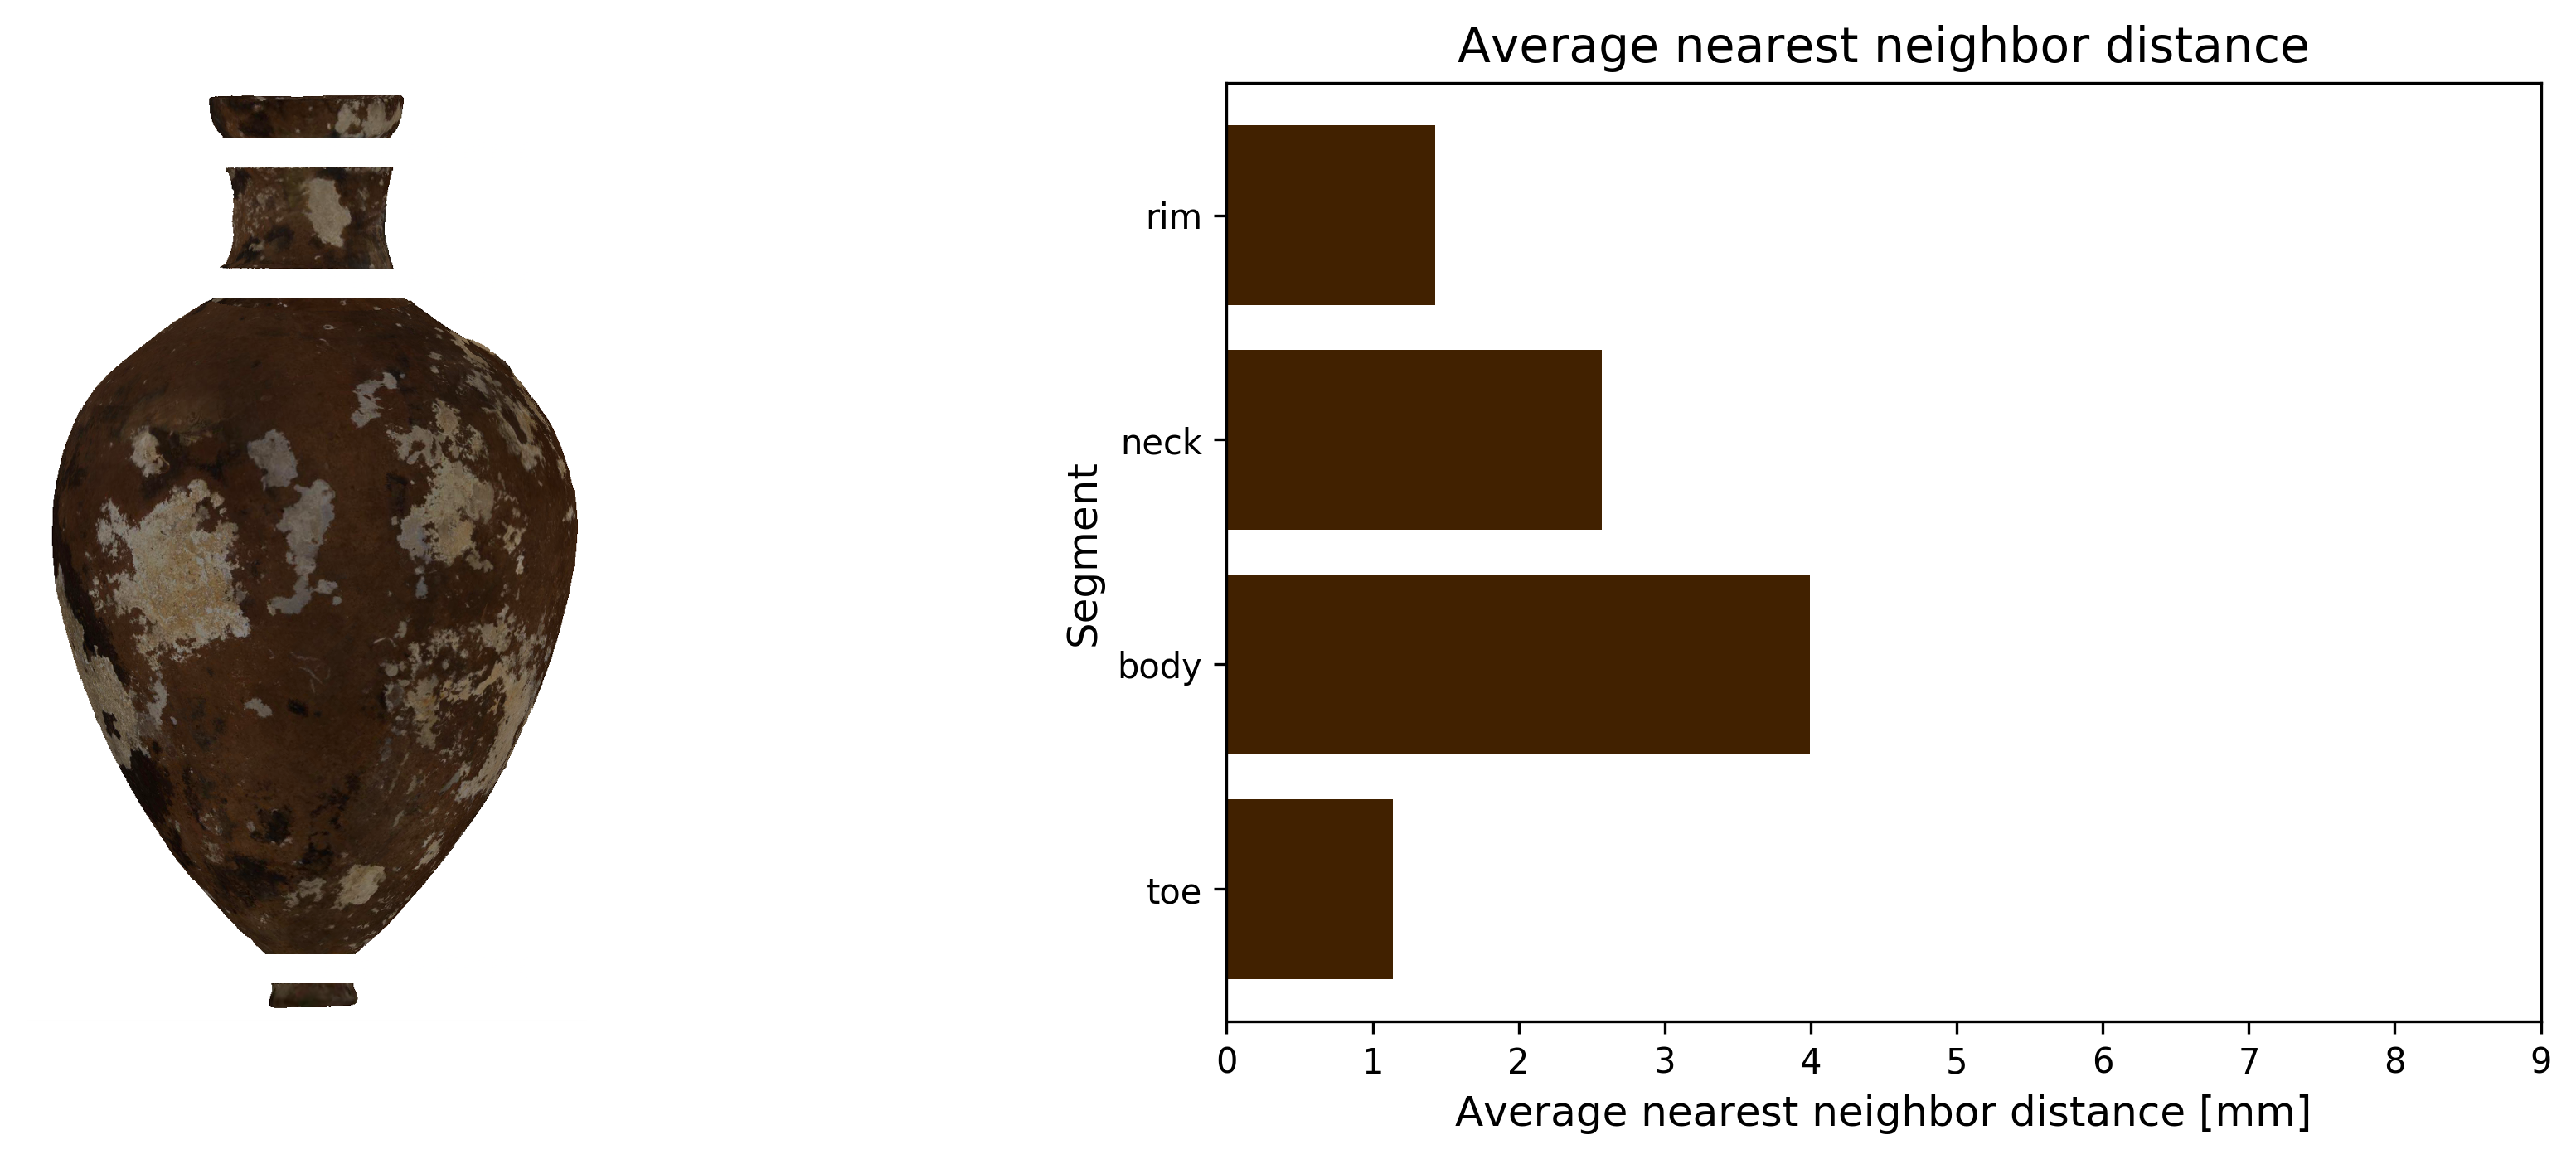

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5), dpi=dpi)

im_template = imread('../../L0082_segments.png')
ax[0].imshow(im_template)
ax[0].axis('off')
y_pos = np.arange(len(segments))
ax[1].barh(y_pos, average_distances, color='#412100')
ax[1].set_yticks(y_pos)
ax[1].set_yticklabels(segments)
ax[1].invert_yaxis()
ax[1].set_xlim(0, 9)
ax[1].set_xlabel('Average nearest neighbor distance [mm]', fontsize=fontsize_xlabel)
ax[1].set_ylabel('Segment', fontsize=fontsize_ylabel)
ax[1].set_title('Average nearest neighbor distance', fontsize=fontsize_title)
plt.show()

### Visualize average distances across segments, scaled for each segment's max diameter

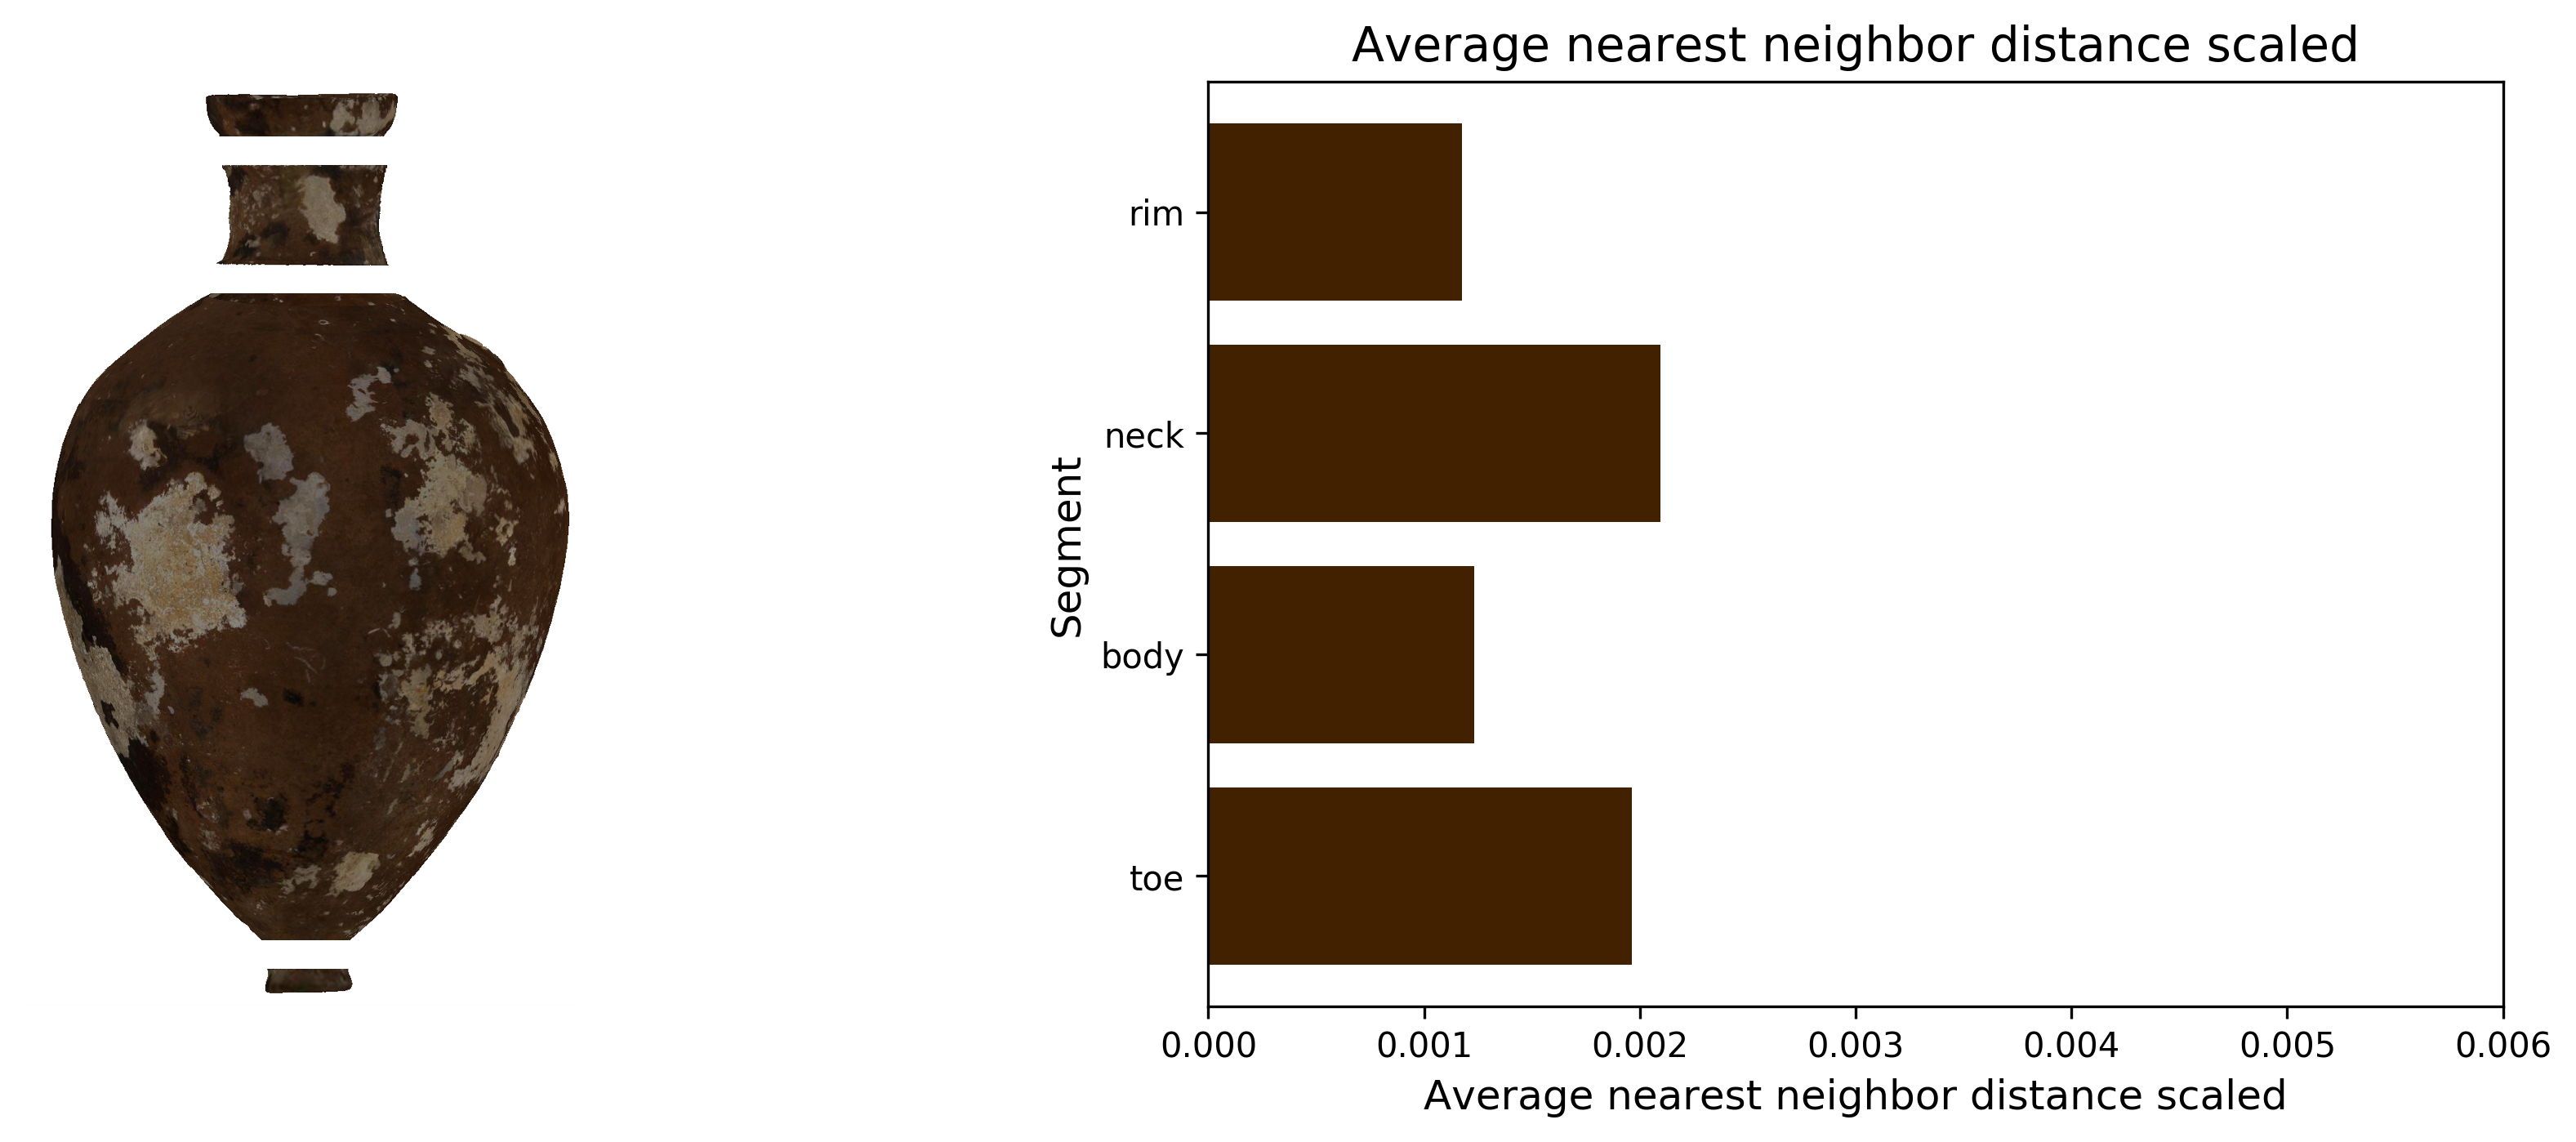

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5), dpi=dpi)
average_distances_scaled = [nnd/(diameter*10) for nnd, diameter in zip(average_distances, diameters)]

im_template = imread('../../L0082_segments.png')
ax[0].imshow(im_template)
ax[0].axis('off')
y_pos = np.arange(len(segments))
ax[1].barh(y_pos, average_distances_scaled, color='#412100')
ax[1].set_yticks(y_pos)
ax[1].set_yticklabels(segments)
ax[1].invert_yaxis()
ax[1].set_xlim(0, 0.006)
ax[1].set_xlabel('Average nearest neighbor distance scaled', fontsize=fontsize_xlabel)
ax[1].set_ylabel('Segment', fontsize=fontsize_ylabel)
ax[1].set_title('Average nearest neighbor distance scaled', fontsize=fontsize_title)
plt.show()

### Visualize the spread of distances across segments

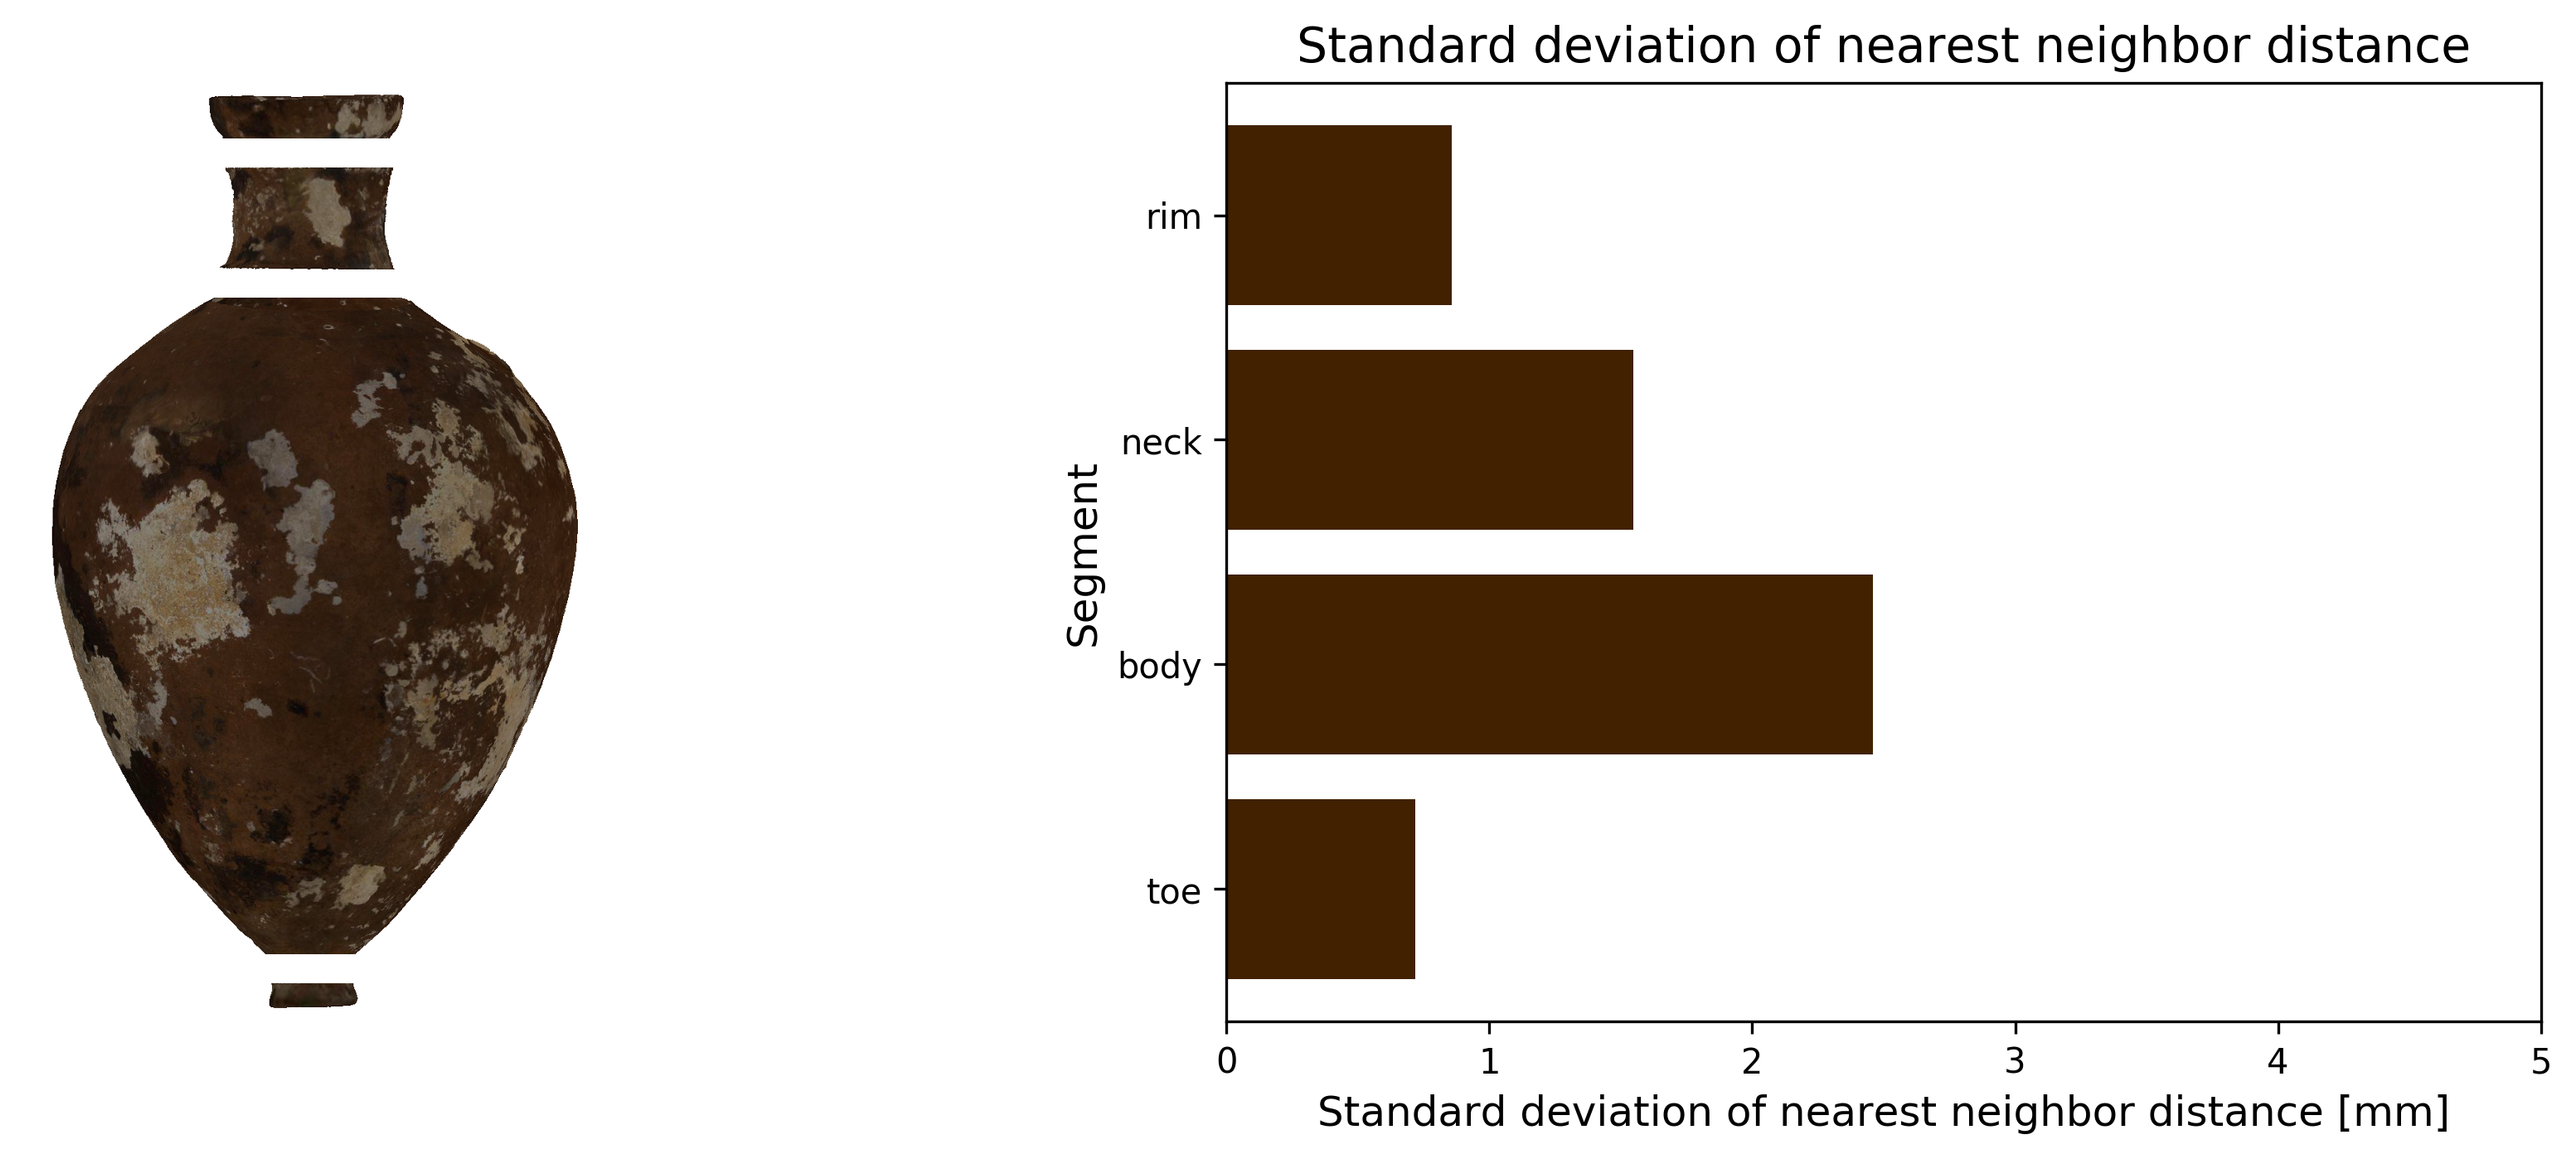

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5), dpi=dpi)

im_template = imread('../../L0082_segments.png')
ax[0].imshow(im_template)
ax[0].axis('off')
y_pos = np.arange(len(segments))
ax[1].barh(y_pos, stdev_distances, color='#412100')
ax[1].set_yticks(y_pos)
ax[1].set_yticklabels(segments)
ax[1].invert_yaxis()
ax[1].set_xlim(0, 5)
ax[1].set_xticks(np.arange(0, 6, 1))
ax[1].set_xlabel('Standard deviation of nearest neighbor distance [mm]', fontsize=fontsize_xlabel)
ax[1].set_ylabel('Segment', fontsize=fontsize_ylabel)
ax[1].set_title('Standard deviation of nearest neighbor distance', fontsize=fontsize_title)
plt.show()

### Visualize distance coefficient of variation across segments

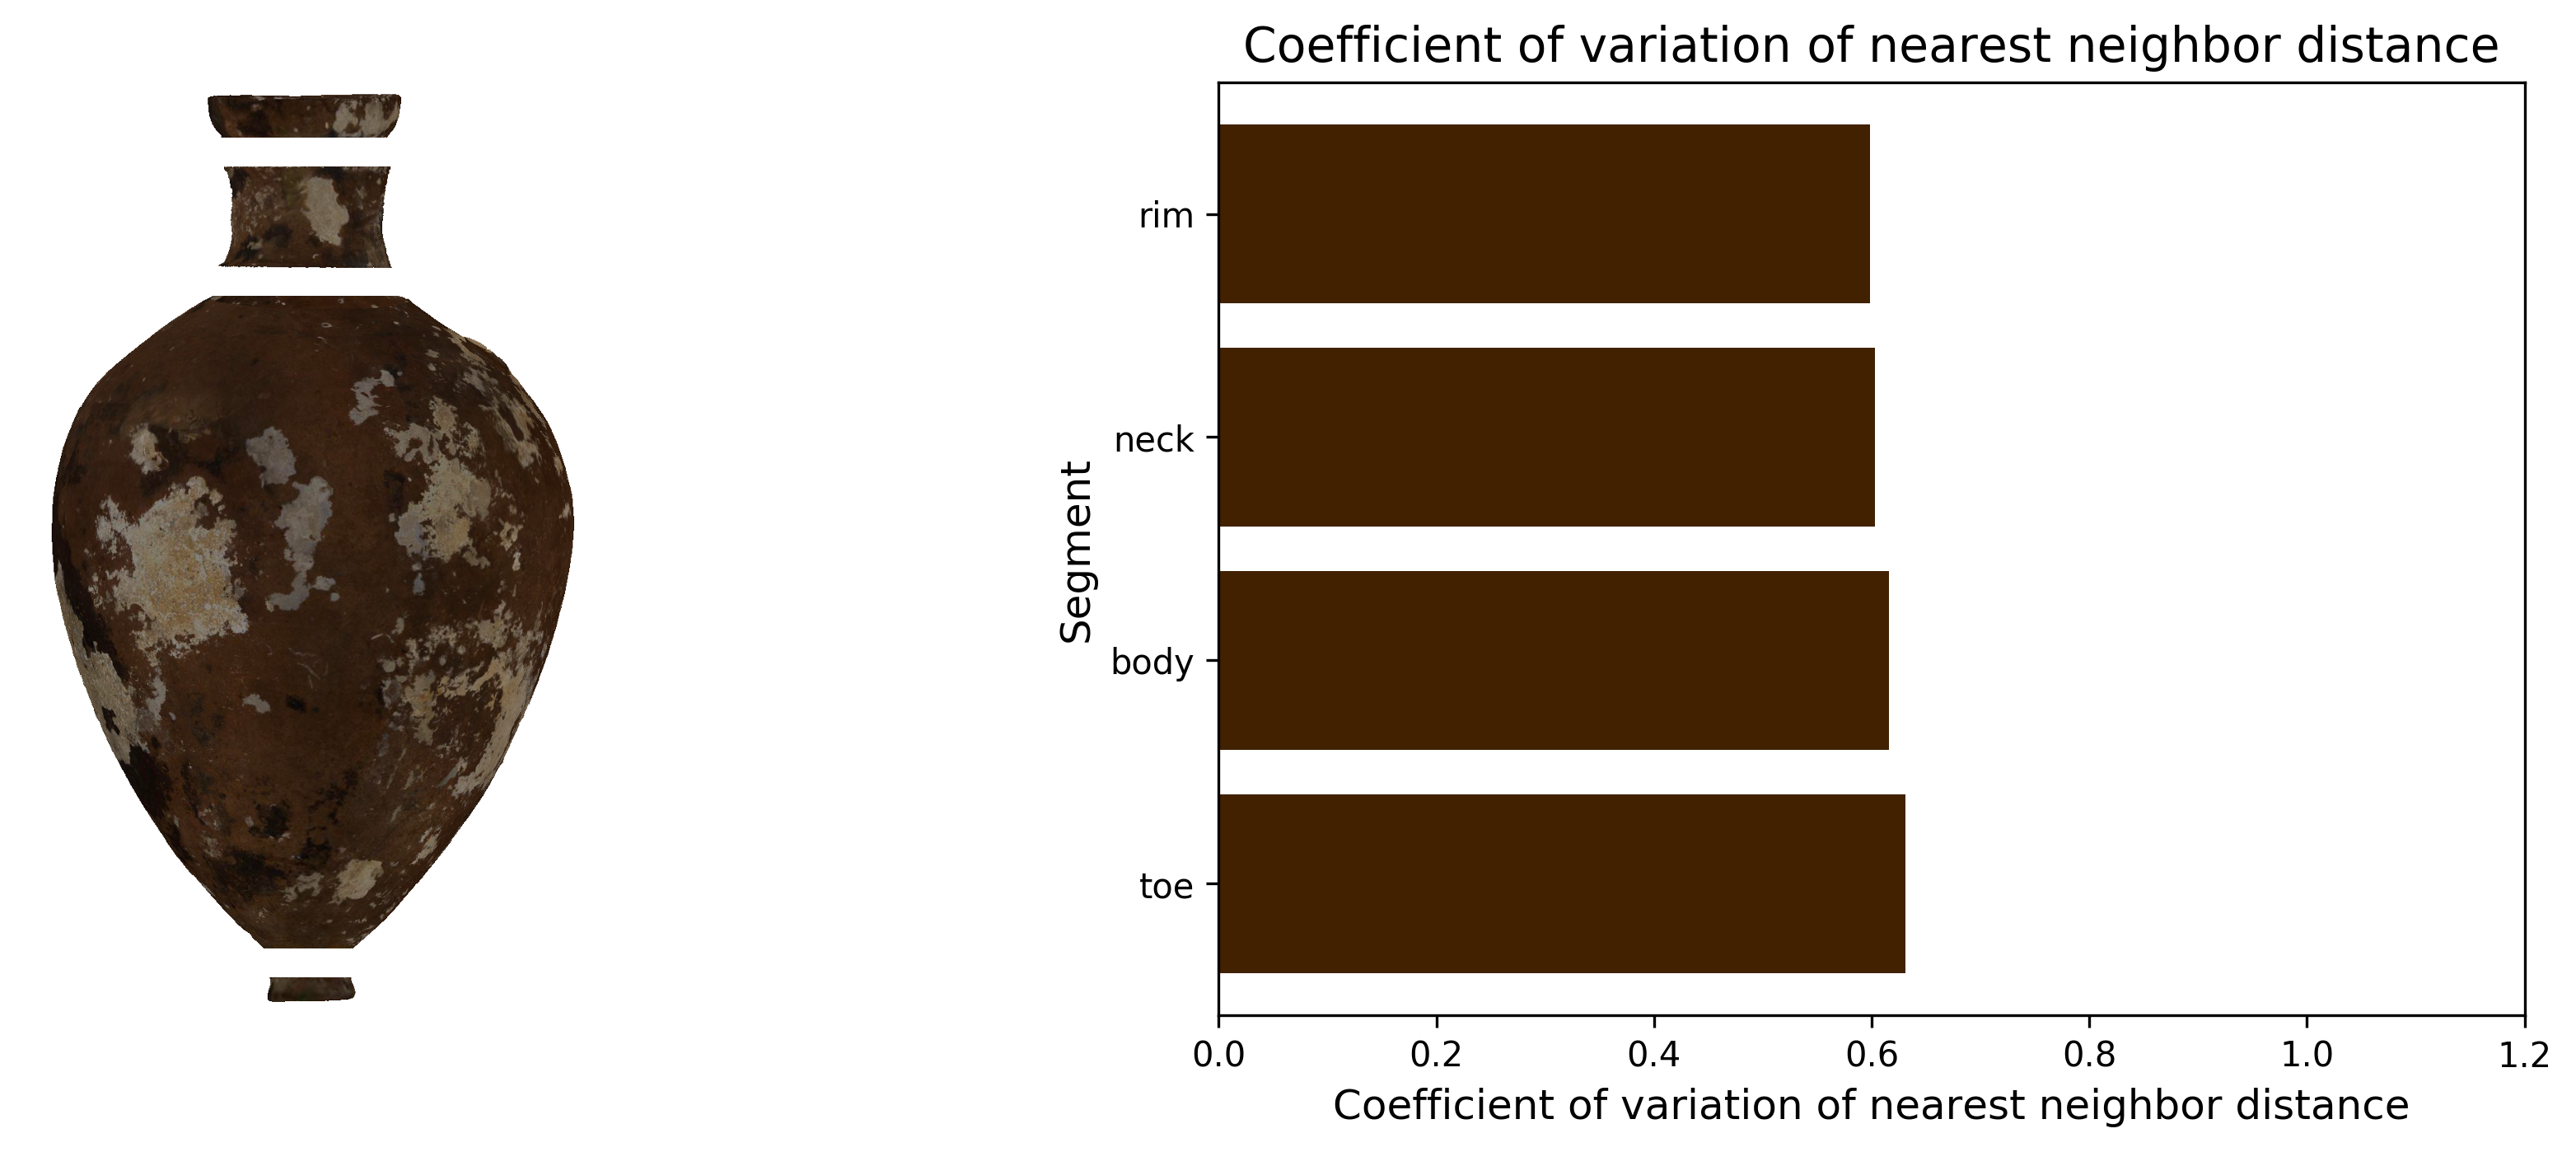

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5), dpi=dpi)
cvs = [stdev/mean for stdev, mean in zip(stdev_distances, average_distances)]

im_template = imread('../../L0082_segments.png')
ax[0].imshow(im_template)
ax[0].axis('off')
y_pos = np.arange(len(segments))
ax[1].barh(y_pos, cvs, color='#412100')
ax[1].set_yticks(y_pos)
ax[1].set_yticklabels(segments)
ax[1].invert_yaxis()
ax[1].set_xlim(0, 1.2)
ax[1].set_xticks(np.arange(0, 1.3, .2))
ax[1].set_xlabel('Coefficient of variation of nearest neighbor distance', fontsize=fontsize_xlabel)
ax[1].set_ylabel('Segment', fontsize=fontsize_ylabel)
ax[1].set_title('Coefficient of variation of nearest neighbor distance', fontsize=fontsize_title)
plt.show()